-----
# cartoGRAPHs - FEATURE TUNING

A Notebook to produce 2D and 3D network layouts from any Graph,
including interactive visualization (html files) and export functions 
to import into the VRNetzer analytics platform by Pirch et al.

Please note: 
Large graphs (e.g. 20k nodes / 300k links) can take ~15min using TSNE-based layouts and ~5min using UMAP-based layouts

-----

In [1]:
from cartoGRAPHs import * 

from func_load_data import *
from func_visual_properties import * 
from func_calculations import * 
from func_embed_plot import * 
from func_exportVR import * 

_____
# 1 | DEFINE NETWORK
_____

In [259]:
G = nx.cycle_graph(9)

l_features = ['nodeID:'+str(i) for i in list(G.nodes())]

In [260]:
path = 'output_plots/benchmark/'

In [261]:
edge_opacity = 1
edge_width = 5
node_size = 45
node_width = 3

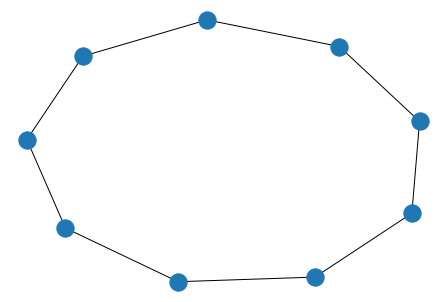

In [262]:
nx.draw(G)

### FUNCTIONAL

In [699]:
rows = len(list(G.nodes()))
feat_one = [(0) if i%3 else (1) for i in range(rows)]
feat_two = [(0) if i%2 or feat_one[i]==1 in feat_one else (1) for i in range(rows)]
feat_three = [(1) if feat_one[i]==0 and feat_two[i]==0 else 0 for i in range(rows)]
feat_matrix = np.vstack((feat_one,feat_two,feat_three))

In [711]:
# colors based on features 

col_one = 'orange' #'darkblue'
col_two = 'cornflowerblue'
col_three = 'skyblue'

colors_assigned = dict(zip(list(G.nodes()), [col_one,col_three,col_two,col_one,col_two,col_three,col_one,col_three,col_two]))
color_list = list(colors_assigned.values())

In [712]:
DF_functional = pd.DataFrame(feat_matrix)
DF_functional.index = [100,101,102]

In [713]:
DF_functional

,0,1,2,3,4,5,6,7,8
100,1,0,0,1,0,0,1,0,0
101,0,0,1,0,1,0,0,0,1
102,0,1,0,0,0,1,0,1,0


In [775]:
n_neighbors=2
spread=1
min_dist=0.0
metric='cosine'

umap2D_functional = embed_umap_2D(DF_functional.T, n_neighbors, spread, min_dist, metric)
posG_functional = get_posG_2D_norm(G, DF_functional.T, umap2D_functional)

In [776]:
trace_nodes = get_trace_nodes_2D(posG_functional, list(G.nodes()), color_list, size=node_size, linewidth=node_width)
trace_edges = get_trace_edges_2D(G, posG_functional, color='dimgrey', opac=edge_opacity, linewidth=edge_width)

data = [trace_edges,trace_nodes]
fname = 'FeatureTuning_Func_'+'nn'+str(n_neighbors)+'_spr'+str(spread)+'_min'+str(min_dist)

In [777]:
fig = pgo.Figure()
    
for i in data:
    fig.add_trace(i)
        
fig.update_layout(template= 'plotly_white', 
                      showlegend=False, width=1200, height=1200,
                          scene=dict(
                              xaxis_title='',
                              yaxis_title='',
                              xaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                              yaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                        ))    
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.write_image(path+fname+'.pdf')

### STRUCTURAL 

In [717]:
r=0.9
alpha=1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DF_structural = pd.DataFrame(FM_m_array).T
DF_structural.index = list(G.nodes())
DF_structural.columns = list(G.nodes()) 

In [718]:
DF_structural

,0,1,2,3,4,5,6,7,8
0,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340
1,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273
2,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114
3,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006
4,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006
5,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114
6,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273
7,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340
8,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534


In [719]:
# normalize DF structural

cols = DF_structural.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(DF_structural)
DF_structural_normalized = pd.DataFrame(np_scaled, columns = cols)
#DF_structural_normalized

DF_structural_normalized_round = DF_structural_normalized.round(8)
DF_structural_normalized_round

,0,1,2,3,4,5,6,7,8
0,1.000000,0.050119,0.002506,0.000119,0.000000,0.000000,0.000119,0.002506,0.050119
1,0.050119,1.000000,0.050119,0.002506,0.000119,0.000000,0.000000,0.000119,0.002506
2,0.002506,0.050119,1.000000,0.050119,0.002506,0.000119,0.000000,0.000000,0.000119
3,0.000119,0.002506,0.050119,1.000000,0.050119,0.002506,0.000119,0.000000,0.000000
4,0.000000,0.000119,0.002506,0.050119,1.000000,0.050119,0.002506,0.000119,0.000000
5,0.000000,0.000000,0.000119,0.002506,0.050119,1.000000,0.050119,0.002506,0.000119
6,0.000119,0.000000,0.000000,0.000119,0.002506,0.050119,1.000000,0.050119,0.002506
7,0.002506,0.000119,0.000000,0.000000,0.000119,0.002506,0.050119,1.000000,0.050119
8,0.050119,0.002506,0.000119,0.000000,0.000000,0.000119,0.002506,0.050119,1.000000


In [772]:
n_neighbors = 2 #4
spread = 1
min_dist = 0.0 #0.1
metric='cosine'

umap2D_structural = embed_umap_2D(DF_structural_normalized_round, n_neighbors, spread, min_dist, metric)
posG_structural = get_posG_2D_norm(G, DF_structural_normalized_round, umap2D_structural)

In [773]:
trace_nodes = get_trace_nodes_2D(posG_structural, list(G.nodes()), color_list, size=node_size, linewidth=node_width)
trace_edges = get_trace_edges_2D(G, posG_structural, color='dimgrey', opac=edge_opacity, linewidth=edge_width)

data = [trace_edges,trace_nodes]
fname = 'FeatureTuning_Struc_'+'nn'+str(n_neighbors)+'_spr'+str(spread)+'_min'+str(min_dist)

In [774]:
fig = pgo.Figure()
    
for i in data:
    fig.add_trace(i)
        
fig.update_layout(template= 'plotly_white', 
                      showlegend=False, width=1200, height=1200,
                          scene=dict(
                              xaxis_title='',
                              yaxis_title='',
                              xaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                              yaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                        ))    
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.write_image(path+fname+'.pdf')

### BOTH INTO ONE MATRIX (structural + functional)

In [731]:
scalar = 1
DF_functional_scal = DF_functional*scalar
DF_functional_scal

,0,1,2,3,4,5,6,7,8
100,1,0,0,1,0,0,1,0,0
101,0,0,1,0,1,0,0,0,1
102,0,1,0,0,0,1,0,1,0


In [732]:
DF_merge = pd.concat([DF_structural_normalized_round, 
                      DF_functional_scal])

In [769]:
n_neighbors = 2 #int(len(G.nodes()))#*0.75)
spread = 1
min_dist = 0.0 #0
metric='cosine'

umap2D_merge = embed_umap_2D(DF_merge , n_neighbors, spread, min_dist, metric)
posG_merge = get_posG_2D_norm(G, DF_merge , umap2D_merge)

In [770]:
trace_nodes = get_trace_nodes_2D(posG_merge, list(G.nodes()), color_list, size=node_size, linewidth=node_width)
trace_edges = get_trace_edges_2D(G, posG_merge, color='dimgrey', opac=edge_opacity ,linewidth=edge_width)

data = [trace_edges,trace_nodes]
fname = 'FeatureTuning_merge_FuncScalar'+str(scalar)

In [771]:
fig = pgo.Figure()
    
for i in data:
    fig.add_trace(i)
        
fig.update_layout(template= 'plotly_white', 
                      showlegend=False, width=1200, height=1200,
                          scene=dict(
                              xaxis_title='',
                              yaxis_title='',
                              xaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                              yaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                        ))    
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.write_image(path+fname+'_'+'nn'+str(n_neighbors)+'_spr'+str(spread)+'_min'+str(min_dist)+'.pdf')